# TP : Proximal coordinate descent method on regression models

#### Authors: R. Gower, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 22th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 16 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "yanlin"
ln1 = "du"
fn2 = "yu"
ln2 = "li"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_du_yanlin_and_li_yu.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

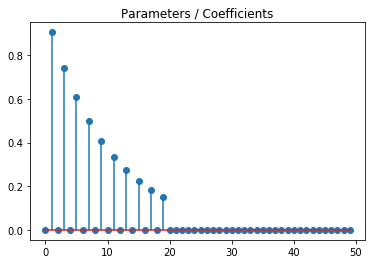

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

### Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return x-(x>s*t)*s*t + (x<-s*t)*s*t - (x<=t*s)*(x>=-t*s)*x 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s*np.linalg.norm(x,1)

def prox_indicator(x, s=1.):
    """Proximal operator for the indicator at x"""    
    return np.maximum(0,x)
    
def indicator(x,s=1.):
    """Value of the indicator penalization at x"""
    return np.inf if np.any(x<0) else 0

(-2, 2)

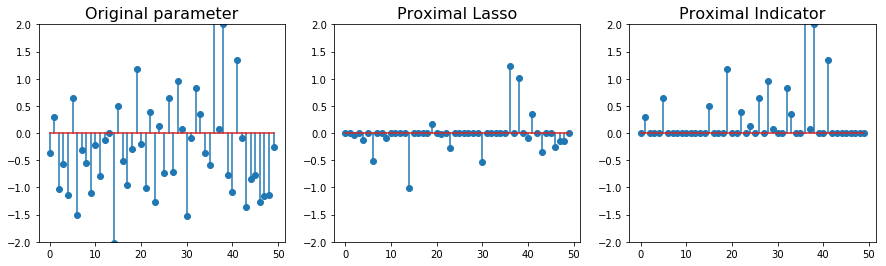

In [7]:
x = randn(50)
l_l1 = 1.

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_indicator(x, s=l_l1))
plt.title("Proximal Indicator", fontsize=16)
plt.ylim([-2, 2])

### Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.

The problem we want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$
Here, we set $ f(x) = \frac{1}{2} \|b - Ax\|^2$. Differentiating $f(x)$ twice we have that 
$$
\nabla^{2} f(x)=A^{T}A
$$
Consequently$$
v^{T}\nabla^{2} f(x)v=v^{T}A^{T}Av=\|Av\|_{2}^{2}\geq 0
$$
$f(x)$ is convex and differentiable.

What's more, we consider
- Lasso penalization, where $g(x) = s \|x\|_1$. Lasso penalization can be separable as $g(x) = s \sum_{i=1}^{n}g_{i}(x^{(i)}) = s \sum_{i=1}^n|x_{i}|$; Lasso penalization is convex because we can easily get $\|\lambda x+(1-\lambda)y\|\leq\|\lambda x\|+\|(1-\lambda)y\|\leq\lambda \|x\|+(1-\lambda)\|y\|$, for $x,y\in \mathbb{R^{d}}$ and $\lambda\in {[0,1]}$. 


- Indicator function of $\mathbb{R}^n_+$, where $g(x) = i_{x \in \mathbb{R}_+^n}(\cdot)$. Indicator function can be separable as $g(x) = \sum_{i=1}^{n}g_{i}(x^{(i)}) = \sum_{i=1}^ni_{x_{i} \in \mathbb{R}_+^n}(\cdot)$; Indicator function is convex beacause of the convexity of ${R}_+^n$ is convex.

In all, $f(x)$ is convex, differentiable and the two $g(x)$ we will use are separable and convex. The objective function $F(x)= f(x)+\sum_{i=1}^{n}g_{i}(x^{(i)})$.
Therefore, proximal coordinate descent can be applied to obtain a minimum of such objective functions.

### Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Here what we do is to implement a proximal coordinate descent method for both penalties. 
- What's more, we show the distance to the minimum and distance to minimiser for both Lasso / L1 linear regression and NNLS, where the minimum is the value of objective function we get after 500 iterations and the minimiser is its corresponding x.


In [8]:
from numpy.linalg import norm

In [9]:
def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape
    #residual
    r = b-np.dot(A,x)
    Li = np.sum(A * A, axis=0)
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Launching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(n_iter + 1):

        #### TODO ####
        i = k % n_features
        x_new[i] = prox_g(x[i] + 1./ Li[i] * np.dot(A[:,i].T, r), s/Li[i])
        #smart residual update
        r+=(x[i]-x_new[i])*A[:,i]
        x = x_new.copy()
        
        obj = 0.5 * np.linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [10]:
A, b = simu_linreg(coefs)
x0 = np.zeros(n_features)
n_iter = 10 * n_features
s = 1e-2

In [11]:
#with lasso
x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0, A, b, lasso , 
                                                    prox_lasso, s, n_iter,x_true=coefs, verbose=False)
print("The minimum of the linear regression with lasso penalization using proximal coordinate descent with 500 iterations: "),
print(objectives_lasso[-1])
print("The minimizer of the linear regression with lasso penalization using proximal coordinate descent with 500 iterations: "),
print(x_lasso)
min_lasso = objectives_lasso[-1]
x_min_lasso = x_lasso

#with indicator
x_nnls, objectives_nnls, errors_nnls = cd_linreg(x0, A, b, indicator , 
                                                    prox_indicator, s, n_iter,x_true=coefs, verbose=False)
print("The minimum of NNLS using proximal coordinate descent with 500 iterations: "),
print(objectives_nnls[-1])
print("The minimizer of NNLS using proximal coordinate descent with 500 iterations: "),
print(x_nnls)
min_nnls = objectives_nnls[-1]
x_min_nnls = x_nnls

The minimum of the linear regression with lasso penalization using proximal coordinate descent with 500 iterations: 
454.159226684
The minimizer of the linear regression with lasso penalization using proximal coordinate descent with 500 iterations: 
[ 0.06  0.92 -0.07  0.73 -0.02  0.64 -0.05  0.51 -0.05  0.47 -0.01  0.32
 -0.02  0.33 -0.05  0.25  0.04  0.16 -0.01  0.15 -0.02  0.05 -0.09  0.04
 -0.02  0.04  0.05  0.05 -0.02  0.    0.04 -0.07  0.04 -0.01 -0.01  0.02
 -0.03  0.03  0.01 -0.06  0.05 -0.08  0.07 -0.02 -0.09  0.09 -0.07  0.06
 -0.02 -0.03]
The minimum of NNLS using proximal coordinate descent with 500 iterations: 
469.410365528
The minimizer of NNLS using proximal coordinate descent with 500 iterations: 
[  5.54e-02   8.84e-01   0.00e+00   6.88e-01   0.00e+00   6.34e-01
   0.00e+00   4.68e-01   0.00e+00   4.57e-01   0.00e+00   3.00e-01
   0.00e+00   3.04e-01   0.00e+00   2.35e-01   2.95e-02   1.68e-01
   0.00e+00   1.35e-01   0.00e+00   7.79e-03   0.00e+00   7.53e-04
   0.00e

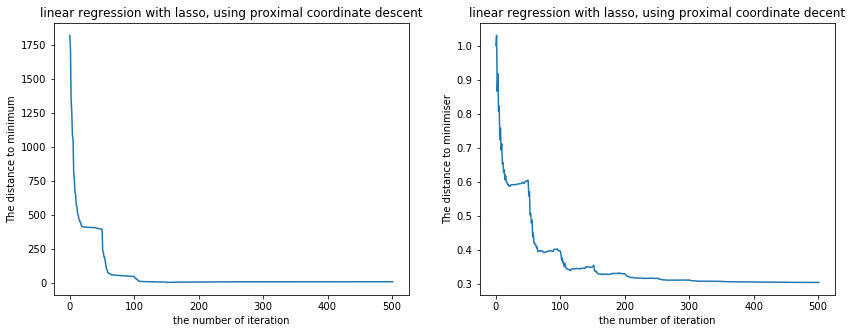

In [12]:
A,b = simu_linreg(coefs)
x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0, A, b, lasso , 
                                                    prox_lasso, s, n_iter,x_true=x_min_lasso, verbose=False)
plt.figure(figsize=(14.0,5.0))
#Here we set the distance to minimum = |the value of objective function-the value of objective function in 500 iteration| 
plt.subplot(1,2,1)
plt.plot(np.arange(len(objectives_lasso)),abs(objectives_lasso- min_lasso))
plt.ylabel("The distance to minimum")
plt.xlabel('the number of iteration')
plt.title("linear regression with lasso, using proximal coordinate descent")
#We can view the error in the algorithm as the distance to the minimiser because here we set the x_true=x we get after 500 iterations 
plt.subplot(1,2,2)
plt.plot(np.arange(len(errors_lasso)),errors_lasso)
plt.ylabel("The distance to minimiser")
plt.xlabel('the number of iteration')
plt.title("linear regression with lasso, using proximal coordinate decent")

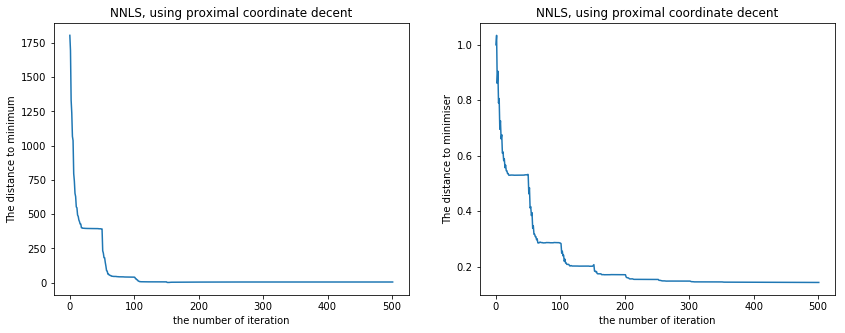

In [13]:
x_nnls, objectives_nnls, errors_nnls = cd_linreg(x0, A, b, indicator , 
                                                 prox_indicator, s, n_iter,x_true=x_min_nnls, verbose=False)
plt.figure(figsize=(14.0,5.0))
#Here we set the distance to minimum = |the value of objective function-the value of objective function in 1000 iteration| 
plt.subplot(1,2,1)
plt.plot(np.arange(len(objectives_nnls)),abs(objectives_nnls- min_nnls))
plt.ylabel("The distance to minimum")
plt.xlabel('the number of iteration')
plt.title("NNLS, using proximal coordinate decent")
#We can view the error in the algorithm as the distance to the minimiser because here we set the x_true=x we get after 500 iterations 
plt.subplot(1,2,2)
plt.plot(np.arange(len(errors_nnls)),errors_nnls)
plt.ylabel("The distance to minimiser")
plt.xlabel('the number of iteration')
plt.title("NNLS, using proximal coordinate decent")

### Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Here what we do is to show the convergence when varying the condition of the problem. It means we have to show the convergence under different A--which is affected by corr. When corr increases, the condition number becomes larger, which means such an optimisation problem is worse conditioned. Therefore in the following work, we focus on the convergences under different corrs 0.1, 0.3, 0.5, 0.7, 0.9.

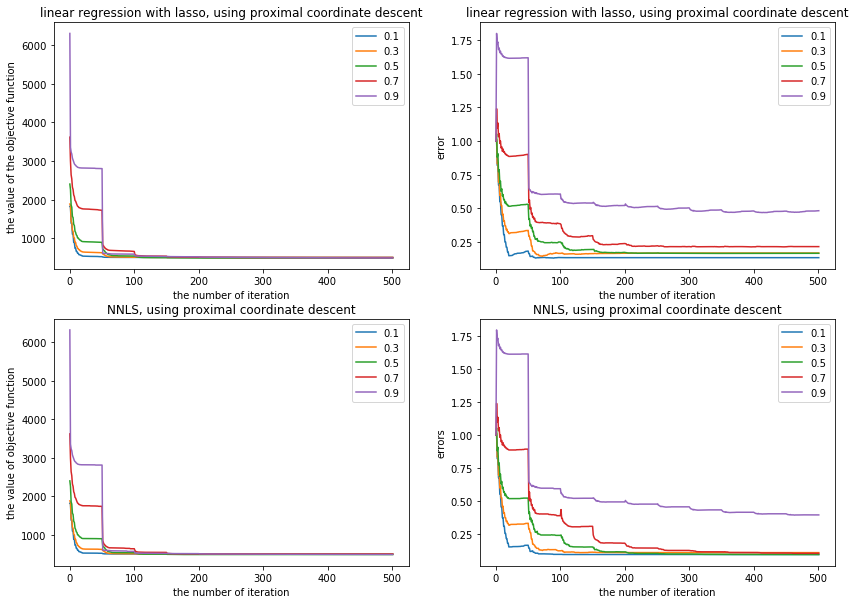

In [14]:
corrs = [0.1,0.3,0.5,0.7,0.9]
plt.figure(figsize=(14.0,10.0))
n_iter = 10 * n_features
s = 1e-2
x0 = np.zeros(n_features)
for corr in corrs:
    
    A,b = simu_linreg(coefs, corr=corr)
    
    x_lasso, objectives_lasso, errors_lasso = cd_linreg(x0, A, b, lasso , 
                                                        prox_lasso, s, n_iter,x_true=coefs, verbose=False)
    
    plt.subplot(2,2,1)
    plt.plot(np.arange(len(objectives_lasso)),objectives_lasso,label=corr)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using proximal coordinate descent")
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(len(errors_lasso)),errors_lasso,label=corr)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using proximal coordinate descent")
    
    
    x_nnls, objectives_nnls, errors_nnls = cd_linreg(x0, A, b, indicator , 
                                                     prox_indicator, s, n_iter,x_true=coefs, verbose=False)
    plt.subplot(2,2,3)
    plt.plot(np.arange(len(objectives_nnls)),objectives_nnls,label=corr)
    plt.legend()
    plt.ylabel("the value of objective function")
    plt.xlabel('the number of iteration')
    plt.title("NNLS, using proximal coordinate descent")
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(len(errors_nnls)),errors_nnls,label=corr)
    plt.legend()
    plt.ylabel("errors")
    plt.xlabel('the number of iteration')
    plt.title("NNLS, using proximal coordinate descent")

From the last 4 figures which show the convergence of coordinate descent with different correlation of the features, we can easily conclude that when the features get more and more correlated, the optimisation algorithm converges to a bigger value. And we can explain this intuitively, if the features are highly correlated, then they provide probably the same information about the target, which makes it more difficult to predict the target. Then the algorithms converge slowly. Lasso regularization arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters.

### Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.
- In order to show that coordinate is much less affected by bad conditionning than proximal gradient descent, we compare the convergences in objective function values and errors under different corrs between two algorithms: fista(proximal gradient descent) and proximal coordinate descent.

In [15]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return (np.linalg.svd(A)[1][0]**2) 

def loss_linreg(x):
    """Least-squares loss"""
    return (1./2.)*np.linalg.norm(b-A.dot(x),2)**2
    
def grad_linreg(x):
    """Least-squares gradient"""
    return  A.T.dot(A.dot(x)- b)

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z - step*grad_f(z),s,step)
        t_new = (1. + np.sqrt(1+4*t**2))/2.
        z = x_new + (t-1.)/t_new*(x_new-x)
        x = x_new
        t = t_new
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)


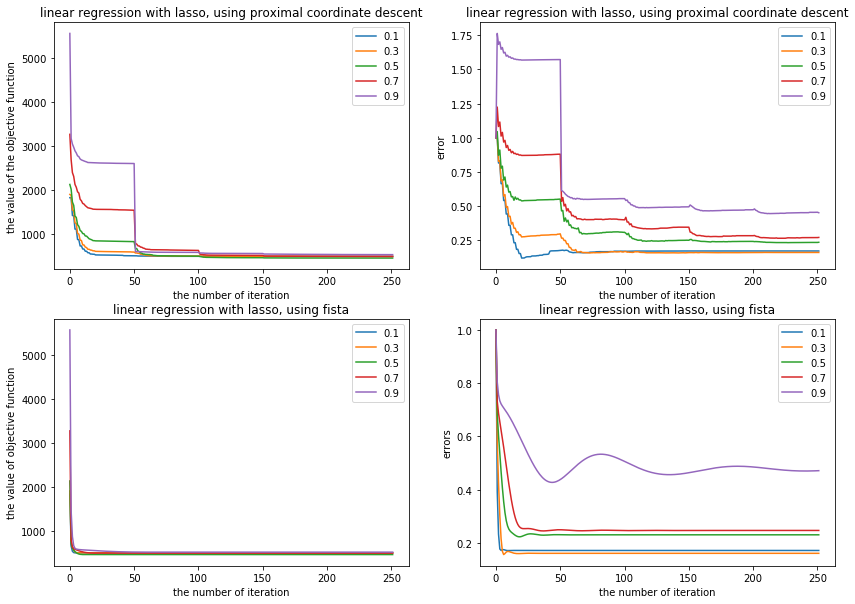

In [16]:
# linear regression
corrs = [0.1,0.3,0.5,0.7,0.9]
plt.figure(figsize=(14.0,10.0))
n_iter= 5* n_features
s = 1e-2
for corr in corrs:
    
    A,b = simu_linreg(coefs, corr=corr)
    step = 1.0/lip_linreg(A)
    x_pcd, objectives_pcd, errors_pcd = cd_linreg(x0, A, b, lasso , 
                                                    prox_lasso, s, n_iter,x_true=coefs, verbose=False)
    plt.subplot(2,2,1)
    plt.plot(np.arange(len(objectives_pcd)),objectives_pcd,label=corr)
    plt.legend()
    plt.ylabel("the value of the objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using proximal coordinate descent")
    
    plt.subplot(2,2,2)
    plt.plot(np.arange(len(errors_pcd)),errors_pcd,label=corr)
    plt.legend()
    plt.ylabel("error")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using proximal coordinate descent")
    
    
    x_fista, objectives_fista, errors_fista = fista(x0, loss_linreg, grad_linreg, lasso, 
                                                    prox_lasso, step, s,n_iter=n_iter,verbose=False)
    plt.subplot(2,2,3)
    plt.plot(np.arange(len(objectives_fista)),objectives_fista,label=corr)
    plt.legend()
    plt.ylabel("the value of objective function")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using fista")
    
    plt.subplot(2,2,4)
    plt.plot(np.arange(len(errors_fista)),errors_fista,label=corr)
    plt.legend()
    plt.ylabel("errors")
    plt.xlabel('the number of iteration')
    plt.title("linear regression with lasso, using fista")
    

When the condition varies, compare the error performance of the two algorithms: proximal coordinate descent and fista. It's evident that the convergence rate of fista decreases when the condition gets worse which means the correlation of features increases. On the contrary, although proximal coordinate descent converges to a larger error as the condition getting worse, the convergence rate of this algorithm is almost the same with that of a good condition. So we can see that proximal coordinate descent is much less affected by bad condition than proximal gradient descent(fista). 